<a href="https://colab.research.google.com/github/UERJ-FISICA/ML4PPGF_UERJ/blob/PPGF-2023-2/Exercicios_Rostos_DimensionalReduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mais Exercícios de Redução de Dimensionalidade

Baseado no livro "Python Data Science Handbook" de Jake VanderPlas
https://jakevdp.github.io/PythonDataScienceHandbook/

Usando os dados de rostos do scikit-learn, utilizar as tecnicas de aprendizado de variedade para comparação.

In [1]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

A base de dados tem 2300 imagens de rostos com 2914 pixels cada (47x62)

Vamos visualizar as primeiras 32 dessas imagens

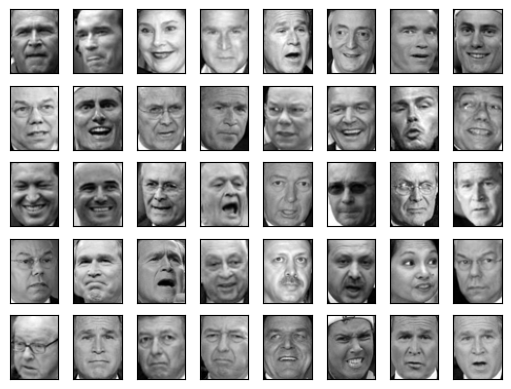

In [2]:
import numpy as np
from numpy import random
from matplotlib import pyplot as plt

%matplotlib inline

fig, ax = plt.subplots(5, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Podemos ver se com redução de dimensionalidade é possível entender algumas das caraterísticas das imagens.


Numero de componentes para 95% de variância preservada: 198


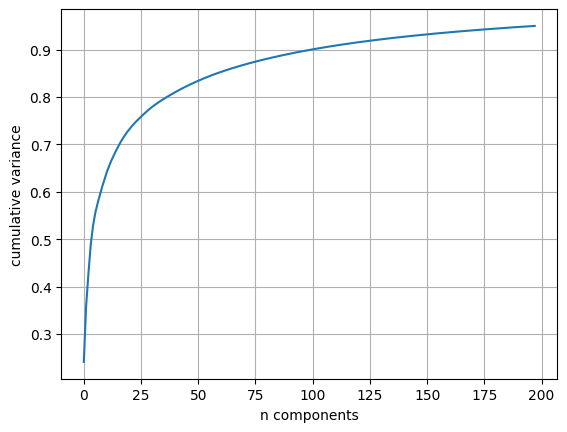

In [3]:
from sklearn.decomposition import PCA


model0 = PCA(n_components=0.95)
X_pca=model0.fit_transform(faces.data)

plt.plot(np.cumsum(model0.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')
plt.grid(True)
print("Numero de componentes para 95% de variância preservada:",model0.n_components_)

Quer dizer que para ter 95% de variância preservada na dimensionalidade reduzida precisamos mais de 170 dimensões (features).

As novas "coordenadas" podem ser vistas em quadros de 11x18 pixels (se d=198)

In [5]:

def plot_faces(instances,  **options):
    fig, ax = plt.subplots(5, 8, subplot_kw=dict(xticks=[], yticks=[]))
    sizex = 11
    sizey = 18
    images = [instance.reshape(sizex,sizey) for instance in instances]


    for i,axi in enumerate(ax.flat):
        axi.imshow(images[i], cmap = "gray", **options)
        axi.axis("off")



Vamos visualizar a compressão dessas imagens

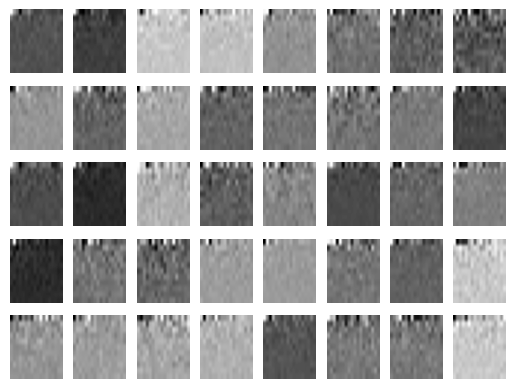

In [6]:
plot_faces(X_pca,aspect="auto")

A opção ```svd_solver=randomized``` faz o PCA  achar as $d$ componentes principais mais rápido quando $d \ll n$, mas o $d$ é fixo. Tem alguma vantagem usar para compressão das imagens de rosto?  Teste!

## Aplicar Isomap para vizualizar em 2D

In [7]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
X_iso = iso.fit_transform(faces.data)
X_iso.shape

(2370, 2)

In [8]:
from matplotlib import offsetbox


def plot_projection(data,proj,images=None,ax=None,thumb_frac=0.5,cmap="gray"):
    ax = ax or plt.gca()

    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05,cmap="gray"):


    proj = model.fit_transform(data)
    plot_projection(data,proj,images,ax,thumb_frac,cmap)


(-30.262252712249754,
 36.60295286178589,
 -23.490522384643555,
 27.390352249145508)

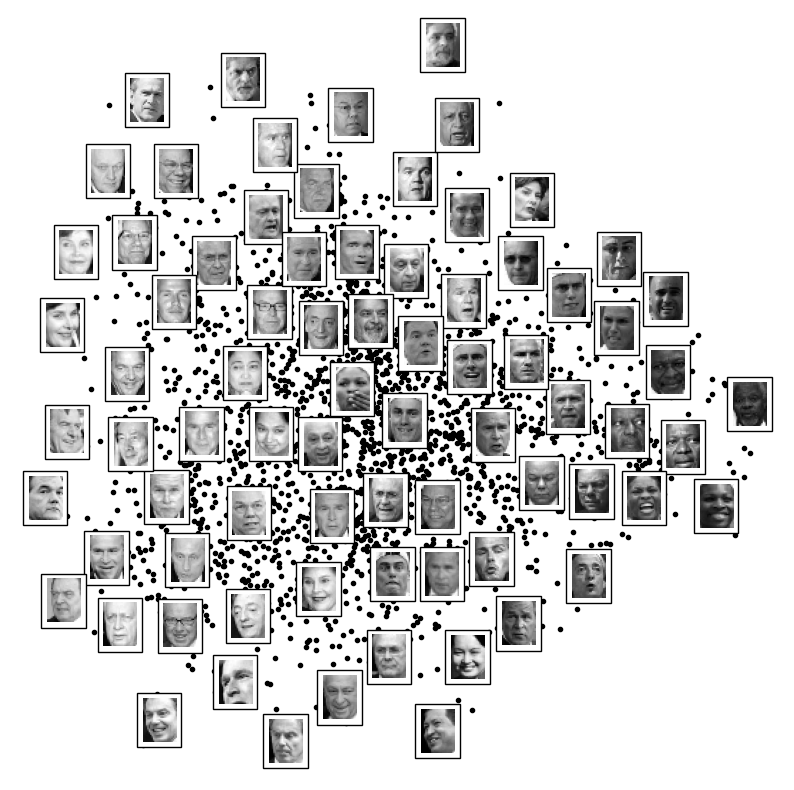

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_projection(faces.data,X_iso,images=faces.images[:, ::2, ::2],thumb_frac=0.07)
ax.axis("off")

As imagens mais a direita são mais escuras que as da direita (seja iluminação ou cor da pele), as imagens mais embaixo estão orientadas com o rosto à esquerda e as de cima com o rosto à direita.


## Exercícios:
1.   Aplicar LLE à base de dados dos rostos e visualizar em mapa 2D, em particular a versão "modificada" ([link](https://scikit-learn.org/stable/modules/manifold.html#modified-locally-linear-embedding))
2.   Aplicar t-SNE à base de dados dos rostos e visualizar em mapa 2D
3.   Escolher mais uma implementação de aprendizado de variedade do Scikit-Learn ([link](https://scikit-learn.org/stable/modules/manifold.html)) e aplicar ao mesmo conjunto. (*Hessian, LTSA, Spectral*)

Qual funciona melhor? Adicione contador de tempo para comparar a duração de cada ajuste.


   

## Kernel PCA e sequências

Vamos ver novamente o exemplo do rocambole


(-12.0, 15.0)

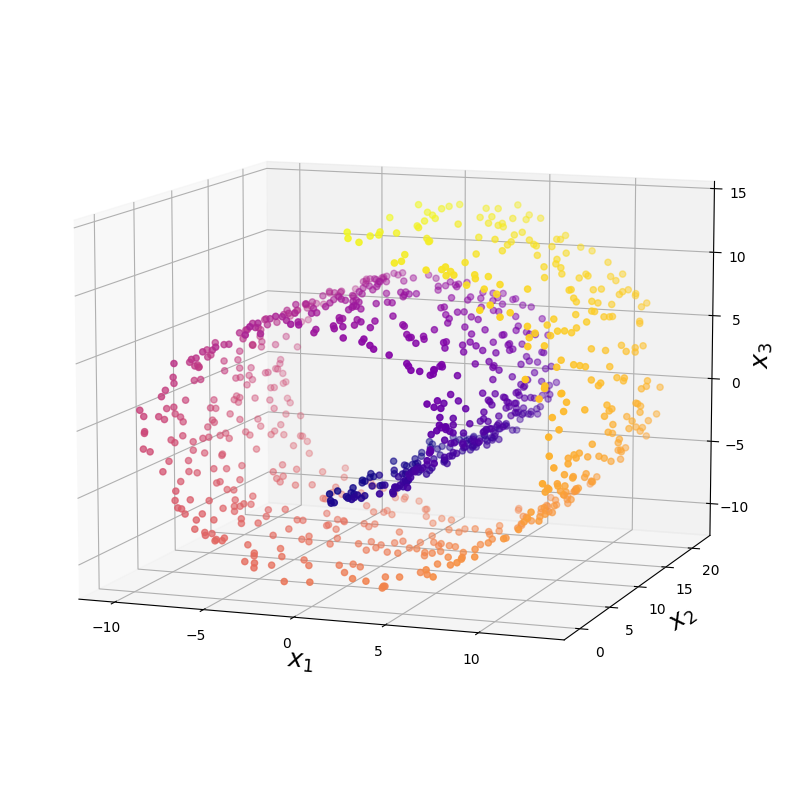

In [10]:
import numpy as np
from numpy import random
from matplotlib import pyplot as plt

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap="plasma")
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])




Como foi no caso do SVM, pode se aplicar uma transformação de *kernel*, para ter um novo espaço de *features* onde pode ser aplicado o PCA. Embaixo o exemplo de PCA com kernel linear (equiv. a aplicar o PCA),  RBF (*radial basis function*) e *sigmoide* (i.e. logístico).

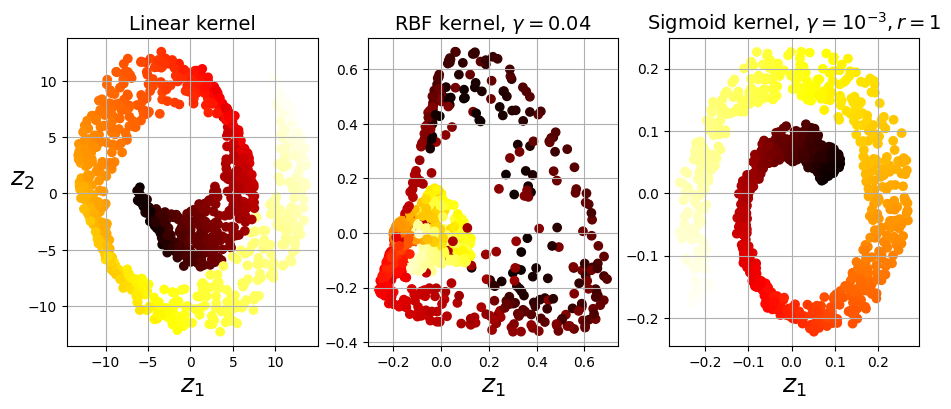

In [11]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced

    plt.subplot(subplot)

    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)



## Selecionar um Kernel e Otimizar Hiperparâmetros

Como estos são algoritmos não supervisionados, no existe uma forma "obvia" de determinar a sua performance.

Porém a redução de dimensionalidade muitas vezes é um passo preparatório para uma outra tarefa de aprendizado supervisionado. Nesse caso é possível usar o ```GridSearchCV``` para avaliar a melhor performance no passo seguinte, com um ```Pipeline```. A classificação será em base ao valor do ```t``` com limite arbitrário de 6.9.


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

y = t>6.9  ## a variavel t é a que da a "cor" no rocambole

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="liblinear"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [14]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [16]:
X_test, t_test = make_swiss_roll(n_samples=100, noise=0.2, random_state=41)


In [17]:
t_predict = grid_search.best_estimator_.predict(X_test)

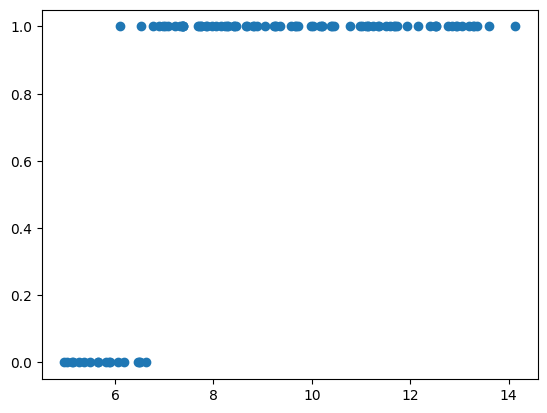

In [28]:
plt.scatter(t_test,t_predict)
plt.show()

In [29]:
from sklearn.metrics import accuracy_score
print(accuracy_score(t_test>6.9,t_predict))

### Exercício :

Varie o valor do corte em ```t``` e veja tem faz alguma diferência para o kernel e hiperparámetros ideais.

### Inverter a transformação e erro de Reconstrução

Outra opção seria escolher o kernel e hiperparâmetros que tem o menor erro de reconstrução.

O seguinte código, com opção ```fit_inverse_transform=True```, vai fazer junto com o kPCA um modelo de regressão com as instancias projetadas (```X_reduced```) de treino e as originais (```X```) de target. O resultado do ```inverse_transform``` será uma tentativa de reconstrução no espaço original .

In [31]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=13./300.,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)
X_preimage.shape

(1000, 3)

(-12.0, 15.0)

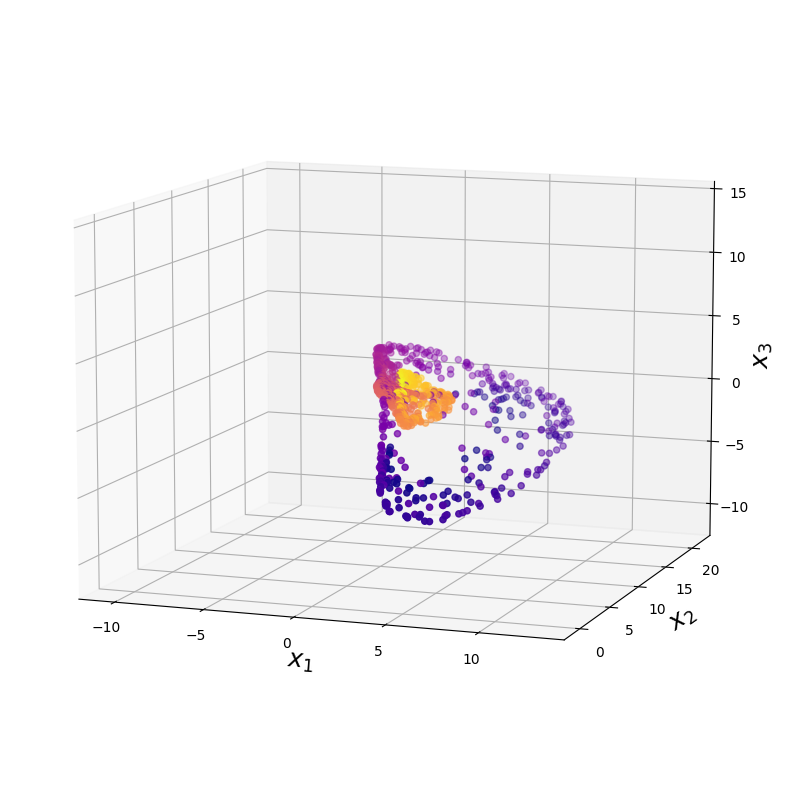

In [32]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_preimage[:, 0], X_preimage[:, 1], X_preimage[:, 2], c=t, cmap="plasma")
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


Então é possível computar o "erro" entre o dataset reconstruido e o original (MSE).

In [33]:
from sklearn.metrics import mean_squared_error as mse

print(mse(X,X_preimage))

32.795235787253375


## Exercício :
 Usar *grid search* com validação no valor do MSE para achar o kernel e hiperparámetros que minimizam este erro, para o exemplo do rocambole.